In [208]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RZZGate
import numpy as np
from qiskit import transpile
import matplotlib.pyplot as plt
from collections import Counter

In [209]:
n_qubits = 3
chi_t_values = np.linspace(0, 1.0, 11)
thetas = np.linspace(0, 2**np.pi, 42)

In [210]:
def apply_one_axis_twist(circuit, qubits, chi_t):
    n = len(qubits)
    for i in range(n):
        for j in range(i + 1, n):
            circuit.append(RZZGate(2 * chi_t), [qubits[i], qubits[j]])
    return circuit

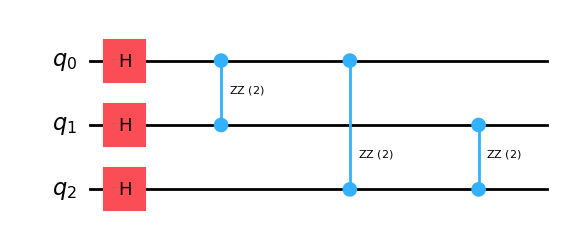

In [211]:
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits)) 
apply_one_axis_twist(qc, list(range(n_qubits)), chi_t) 
    
display(qc.draw(output="mpl"))

In [212]:
# For Z-Basis
backend = AerSimulator()

def calculate_jz_and_delta_jz(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jz_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jz_value
        expectation_sq += prob * (jz_value ** 2)
    
    delta_jz = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jz

# Store all results: (theta, chi_t, delta_jz)
all_results_z = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_z = QuantumCircuit(n_qubits)
        qc_z.h(range(n_qubits))
        apply_one_axis_twist(qc_z, list(range(n_qubits)), chi_t)
        qc_z.measure_all()
        
        job = backend.run(transpile(qc_z, backend), shots=1000)
        counts = job.result().get_counts()
        
        jz, delta_jz = calculate_jz_and_delta_jz(counts, n_qubits=3)
        all_results_z.append((theta, chi_t, delta_jz))

# Find the theta with the smallest min(ΔJz)
theta_min = min(thetas, key=lambda theta: min(delta_jz for t, chi, delta_jz in all_results_z if t == theta))

# Extract all (chi_t, delta_jz) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jz) for t, chi_t, delta_jz in all_results_z if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJz values for this θ:")
for chi_t, delta_jz in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJz = {delta_jz:.4f}")


Optimal θ = 2.583
χt and ΔJz values for this θ:
χt = 0.000 → ΔJz = 0.8108
χt = 0.100 → ΔJz = 0.8750
χt = 0.200 → ΔJz = 0.8854
χt = 0.300 → ΔJz = 0.8565
χt = 0.400 → ΔJz = 0.8599
χt = 0.500 → ΔJz = 0.8746
χt = 0.600 → ΔJz = 0.8620
χt = 0.700 → ΔJz = 0.8487
χt = 0.800 → ΔJz = 0.8779
χt = 0.900 → ΔJz = 0.8692
χt = 1.000 → ΔJz = 0.8516


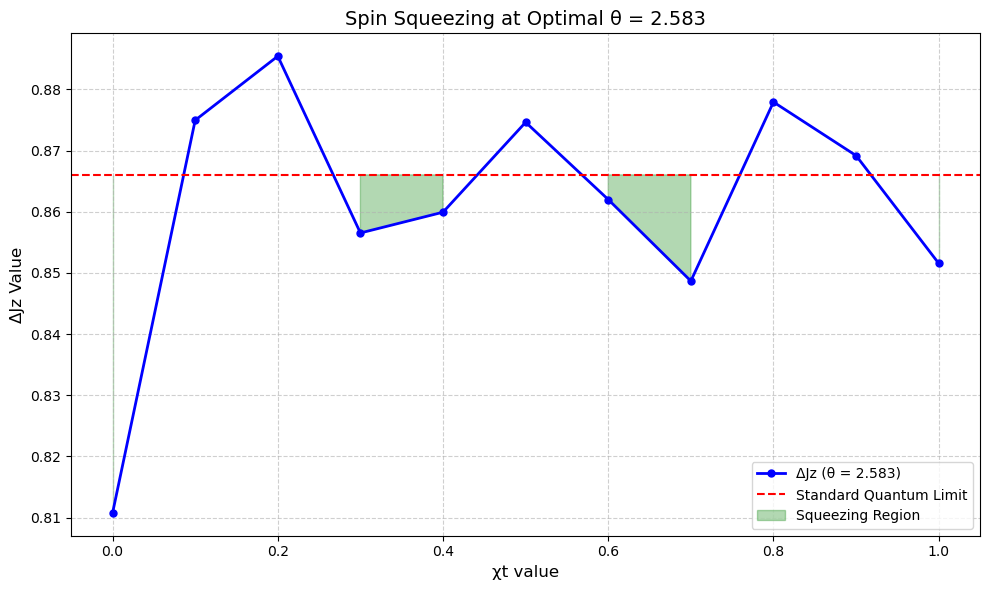

In [213]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jz_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jz_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJz (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jz_vals, sql, 
                 where=(delta_jz_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJz Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [214]:
# For X-Basis
backend = AerSimulator()

def calculate_jx_and_delta_jx(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jx_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jx_value
        expectation_sq += prob * (jx_value ** 2)
    
    delta_jx = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jx

# Store all results: (theta, chi_t, delta_jx)
all_results_x = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_x = QuantumCircuit(n_qubits)
        qc_x.h(range(n_qubits))
        apply_one_axis_twist(qc_x, list(range(n_qubits)), chi_t)
        qc_x.h(range(n_qubits))
        qc_x.measure_all() 
        
        job = backend.run(transpile(qc_x, backend), shots=1000)
        counts = job.result().get_counts()
        
        jx, delta_jx = calculate_jx_and_delta_jx(counts, n_qubits=3)
        all_results_x.append((theta, chi_t, delta_jx))

# Find the theta with the smallest min(ΔJx)
theta_min = min(thetas, key=lambda theta: min(delta_jx for t, chi, delta_jx in all_results_x if t == theta))

# Extract all (chi_t, delta_jx) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jx) for t, chi_t, delta_jx in all_results_x if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJx values for this θ:")
for chi_t, delta_jx in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJx = {delta_jx:.4f}")


Optimal θ = 0.000
χt and ΔJx values for this θ:
χt = 0.000 → ΔJx = 0.0000
χt = 0.100 → ΔJx = 0.3775
χt = 0.200 → ΔJx = 0.6476
χt = 0.300 → ΔJx = 0.8542
χt = 0.400 → ΔJx = 0.9713
χt = 0.500 → ΔJx = 0.9995
χt = 0.600 → ΔJx = 0.9474
χt = 0.700 → ΔJx = 0.9028
χt = 0.800 → ΔJx = 0.8773
χt = 0.900 → ΔJx = 0.9066
χt = 1.000 → ΔJx = 0.9790


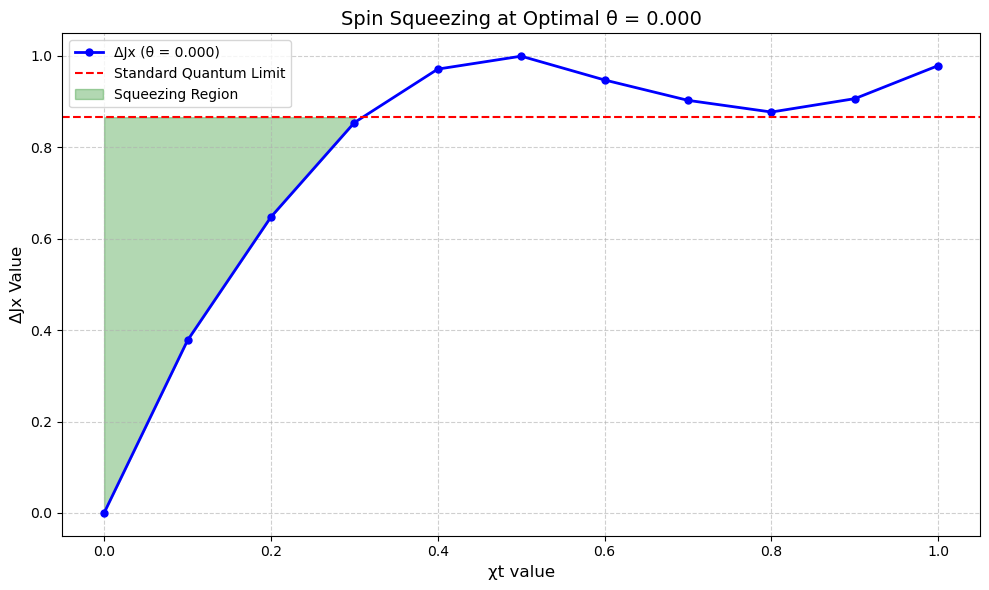

In [215]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jx_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jx_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJx (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jx_vals, sql, 
                 where=(delta_jx_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJx Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [216]:
# For Y-Basis
backend = AerSimulator()

def calculate_jy_and_delta_jy(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jy_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jy_value
        expectation_sq += prob * (jy_value ** 2)
    
    delta_jy = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jy

# Store all results: (theta, chi_t, delta_jy)
all_results_y = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_y = QuantumCircuit(n_qubits)
        qc_y.h(range(n_qubits))
        apply_one_axis_twist(qc_y, list(range(n_qubits)), chi_t)
        qc_y.sdg(range(n_qubits))
        qc_y.h(range(n_qubits))
        qc_y.measure_all()
            
        job = backend.run(transpile(qc_y, backend), shots=1000)
        counts = job.result().get_counts()
        
        jy, delta_jy = calculate_jy_and_delta_jy(counts, n_qubits=3)
        all_results_y.append((theta, chi_t, delta_jy))

# Find the theta with the smallest min(ΔJy)
theta_min = min(thetas, key=lambda theta: min(delta_jy for t, chi, delta_jy in all_results_y if t == theta))

# Extract all (chi_t, delta_jy) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jy) for t, chi_t, delta_jy in all_results_y if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJy values for this θ:")
for chi_t, delta_jy in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJy = {delta_jy:.4f}")


Optimal θ = 5.812
χt and ΔJy values for this θ:
χt = 0.000 → ΔJy = 0.8136
χt = 0.100 → ΔJy = 0.8927
χt = 0.200 → ΔJy = 0.9828
χt = 0.300 → ΔJy = 1.1158
χt = 0.400 → ΔJy = 1.2206
χt = 0.500 → ΔJy = 1.3489
χt = 0.600 → ΔJy = 1.4372
χt = 0.700 → ΔJy = 1.4819
χt = 0.800 → ΔJy = 1.4967
χt = 0.900 → ΔJy = 1.4732
χt = 1.000 → ΔJy = 1.4199


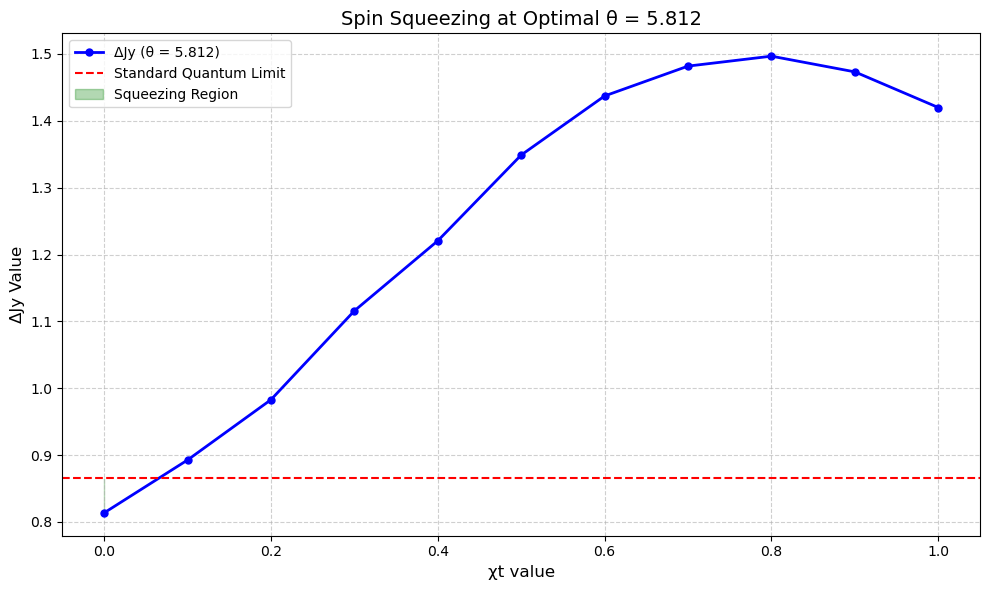

In [217]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jy_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jy_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJy (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jy_vals, sql, 
                 where=(delta_jy_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJy Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

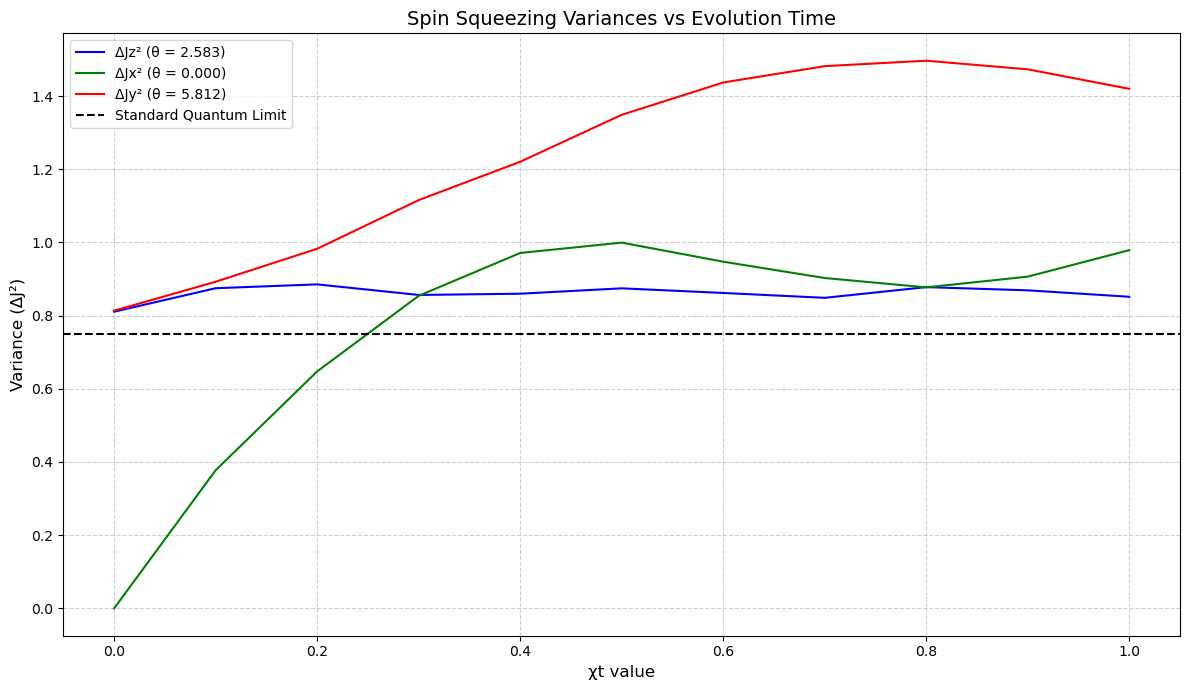

In [218]:
# Create a combined plot
plt.figure(figsize=(12, 7))

theta_min_z = min(thetas, key=lambda theta: min(delta_jz for t, chi, delta_jz in all_results_z if t == theta))
theta_min_x = min(thetas, key=lambda theta: min(delta_jx for t, chi, delta_jx in all_results_x if t == theta))
theta_min_y = min(thetas, key=lambda theta: min(delta_jy for t, chi, delta_jy in all_results_y if t == theta))

results_z = [(chi_t, delta_jz) for t, chi_t, delta_jz in all_results_z if t == theta_min_z]
results_x = [(chi_t, delta_jx) for t, chi_t, delta_jx in all_results_x if t == theta_min_x]
results_y = [(chi_t, delta_jy) for t, chi_t, delta_jy in all_results_y if t == theta_min_y]

plt.plot([r[0] for r in results_z], [r[1] for r in results_z], 'b-', label=f'ΔJz² (θ = {theta_min_z:.3f})')
plt.plot([r[0] for r in results_x], [r[1] for r in results_x], 'g-', label=f'ΔJx² (θ = {theta_min_x:.3f})')
plt.plot([r[0] for r in results_y], [r[1] for r in results_y], 'r-', label=f'ΔJy² (θ = {theta_min_y:.3f})')

sql = n_qubits / 4  # SQL variance
plt.axhline(y=sql, color='k', linestyle='--', label='Standard Quantum Limit')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("Variance (ΔJ²)", fontsize=12)
plt.title("Spin Squeezing Variances vs Evolution Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [219]:
"""
The results I get for the combined plot are very interesting. The Z variance is conserved, with ever-so-slight fluctuations. 
However, until χt = 0.4 the Heisenberg uncertainty principle is not necessarily seen, with both values increasing. And, when the principle
is taken into account, no actual squeezing occurs, which is interesting. I am not sure if that is because of something wrong with my code or
if that is supposed to happen. I do remember from Week 3 or 4 that I modeled data that did not show a correlation between two 
variables until a certain time, and I do not completely remember what those variables were, but something similar could be occurring here.
"""

'\nThe results I get for the combined plot are very interesting. The Z variance is conserved, with ever-so-slight fluctuations. \nHowever, until χt = 0.4 the Heisenberg uncertainty principle is not necessarily seen, with both values increasing. And, when the principle\nis taken into account, no actual squeezing occurs, which is interesting. I am not sure if that is because of something wrong with my code or\nif that is supposed to happen. I do remember from Week 3 or 4 that I modeled data that did not show a correlation between two \nvariables until a certain time, and I do not completely remember what those variables were, but something similar could be occurring here.\n'